In [ ]:
# This project aims at detecting sarcam in the sentences using embedding and 
# neural networks that can be used to further understand the sentiment of sentences.
# Tuned the hyperparameter of model using keras tuner.

In [20]:
#!pip install keras-tuner
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from kerastuner.engine.hyperparameters import HyperParameters
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt

In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [6]:
# downloading the dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-06-19 21:11:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 2607:f8b0:4004:809::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.06s   

2020-06-19 21:11:06 (83.5 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [7]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [8]:
# shuffling and splitting the dataset into train, valid and test dataset

sentences,labels = shuffle(sentences,labels)

training_size = int(0.6 * len(sentences))
val_size = int(0.8 * len(sentences)) - int(0.6 * len(sentences))
test_size = int(1 * len(sentences)) - int(0.8 * len(sentences))

training_sentences = sentences[0:training_size]
val_sentences = sentences[training_size:training_size+val_size]
testing_sentences = sentences[training_size+val_size:]

training_labels = labels[0:training_size]
val_labels = labels[training_size:training_size+val_size]
testing_labels = labels[training_size+val_size:]

In [9]:
# tokeninzing and padding the sentences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=max_length, 
                           padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [10]:
# Need this block to get it to work with TensorFlow 2.x

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

val_padded = np.array(val_padded)
val_labels = np.array(val_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [11]:
# batching the train, val and test dataset

train_dataset = tf.data.Dataset.from_tensor_slices((training_padded, 
                                                    training_labels))
train_dataset = train_dataset.batch(batch_size = 64, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((val_padded, val_labels))
val_dataset = val_dataset.batch(batch_size = 64, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((testing_padded, 
                                                   testing_labels))
test_dataset = test_dataset.batch(batch_size = 64, drop_remainder=True)

In [14]:
# model architecture

def build_model(hp):
  inputs = tf.keras.Input(shape=(100,))                             
  x = tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=
                                100)(inputs)
  x = tf.keras.layers.GlobalAveragePooling1D()(x)
  x = tf.keras.layers.Dense(
      hp.Int('hidden_size', min_value = 32, max_value = 64, step=32, default=24),
      activation='relu',kernel_initializer = tf.initializers.GlorotNormal(),
                kernel_regularizer = tf.keras.regularizers.l2(l=0.01))(x)

  predictions = tf.keras.layers.Dense(1, activation='sigmoid',kernel_regularizer
                                      = tf.keras.regularizers.l2(l=0.01))(x)
                                      
  model = tf.keras.Model(inputs = inputs,outputs = predictions)

  model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),metrics=
        ['accuracy'])
  
  return model

In [15]:
# hperparameter tuning using keras-tuner

hp = HyperParameters()
from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    seed=2,
    max_trials = 20,
    executions_per_trial = 2
)

tuner.search(train_dataset,
             validation_data=val_dataset)

250/250 [==============================] - 1s 5ms/step - loss: 0.8822 - accuracy: 0.5617 - val_loss: 0.8166 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.7542 - accuracy: 0.5638 - val_loss: 0.6928 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.8548 - accuracy: 0.5600 - val_loss: 0.7756 - val_accuracy: 0.5574


250/250 [==============================] - 1s 6ms/step - loss: 0.7957 - accuracy: 0.5584 - val_loss: 0.7271 - val_accuracy: 0.5574


250/250 [==============================] - 1s 6ms/step - loss: 0.7937 - accuracy: 0.5629 - val_loss: 0.7166 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.8602 - accuracy: 0.5638 - val_loss: 0.8089 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.6976 - accuracy: 0.5631 - val_loss: 0.6866 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.7768 - accuracy: 0.5638 - val_loss: 0.7107 - val_accuracy: 0.5574


250/250 [==============================] - 1s 6ms/step - loss: 0.7327 - accuracy: 0.5631 - val_loss: 0.6883 - val_accuracy: 0.5574


250/250 [==============================] - 1s 6ms/step - loss: 0.9091 - accuracy: 0.5638 - val_loss: 0.8532 - val_accuracy: 0.5574


250/250 [==============================] - 1s 6ms/step - loss: 0.6987 - accuracy: 0.5639 - val_loss: 0.6866 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.8336 - accuracy: 0.5638 - val_loss: 0.7501 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.7362 - accuracy: 0.5635 - val_loss: 0.6877 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.7636 - accuracy: 0.5631 - val_loss: 0.7028 - val_accuracy: 0.5574


250/250 [==============================] - 1s 6ms/step - loss: 0.9275 - accuracy: 0.5638 - val_loss: 0.8952 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.7718 - accuracy: 0.5638 - val_loss: 0.7017 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.7668 - accuracy: 0.5638 - val_loss: 0.6958 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.7409 - accuracy: 0.5633 - val_loss: 0.6885 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.8820 - accuracy: 0.5638 - val_loss: 0.8216 - val_accuracy: 0.5574


250/250 [==============================] - 1s 5ms/step - loss: 0.8304 - accuracy: 0.5622 - val_loss: 0.7635 - val_accuracy: 0.5574


INFO:tensorflow:Oracle triggered exit


In [16]:
# Retrieve the best model.

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
best_hyperparameters.values

{'hidden_size': 64, 'learning_rate': 0.0002991777241598977}

In [17]:
# training the model

num_epochs = 200
history = best_model.fit(train_dataset, epochs=num_epochs, 
                         validation_data= val_dataset, verbose=2)

Epoch 1/200
250/250 - 1s - loss: 0.7786 - accuracy: 0.5638 - val_loss: 0.7476 - val_accuracy: 0.5574
Epoch 2/200
250/250 - 1s - loss: 0.7271 - accuracy: 0.5638 - val_loss: 0.7134 - val_accuracy: 0.5574
Epoch 3/200
250/250 - 1s - loss: 0.7033 - accuracy: 0.5638 - val_loss: 0.6979 - val_accuracy: 0.5574
Epoch 4/200
250/250 - 1s - loss: 0.6927 - accuracy: 0.5638 - val_loss: 0.6912 - val_accuracy: 0.5574
Epoch 5/200
250/250 - 1s - loss: 0.6882 - accuracy: 0.5638 - val_loss: 0.6885 - val_accuracy: 0.5574
Epoch 6/200
250/250 - 1s - loss: 0.6865 - accuracy: 0.5638 - val_loss: 0.6875 - val_accuracy: 0.5574
Epoch 7/200
250/250 - 1s - loss: 0.6858 - accuracy: 0.5638 - val_loss: 0.6872 - val_accuracy: 0.5574
Epoch 8/200
250/250 - 1s - loss: 0.6856 - accuracy: 0.5638 - val_loss: 0.6870 - val_accuracy: 0.5574
Epoch 9/200
250/250 - 1s - loss: 0.6855 - accuracy: 0.5638 - val_loss: 0.6869 - val_accuracy: 0.5574
Epoch 10/200
250/250 - 1s - loss: 0.6854 - accuracy: 0.5638 - val_loss: 0.6869 - val_accura

In [18]:
# printing train, valid and test accuracy

train_loss, train_acc = best_model.evaluate(train_dataset)
print('Train Loss: {}'.format(train_loss))
print('Train Accuracy: {}'.format(train_acc))

val_loss, val_acc = best_model.evaluate(val_dataset)
print('val Loss: {}'.format(val_loss))
print('val Accuracy: {}'.format(val_acc))

test_loss, test_acc = best_model.evaluate(test_dataset)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

250/250 [==============================] - 1s 2ms/step - loss: 0.4186 - accuracy: 0.9167
Train Loss: 0.41859978437423706
Train Accuracy: 0.9166874885559082
83/83 [==============================] - 0s 2ms/step - loss: 0.5049 - accuracy: 0.8522
val Loss: 0.5048618316650391
val Accuracy: 0.8522213697433472
83/83 [==============================] - 0s 2ms/step - loss: 0.4975 - accuracy: 0.8537
Test Loss: 0.49746719002723694
Test Accuracy: 0.853727400302887


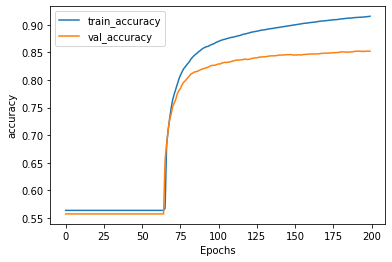

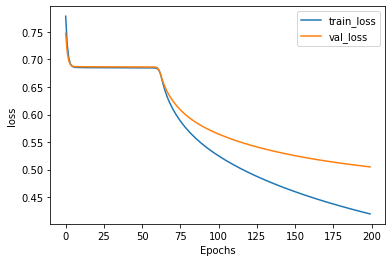

In [21]:
# plotting the model loss and accuracy

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend(['train_'+string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [22]:
# testing the sentences

sentence = ["granny starting to fear spiders in the garden might be real", 
            "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)
print(best_model.predict(padded))

[[0.27219227]
 [0.36375594]]
